In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *
from models.one_pixel_attack import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Define params of model
input_shape = (125,125,3)
num_classes = 10

In [4]:
#%%capture one
#Load model from disk
model_name = 'cifar10-resnet-big'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10-big', transform='dct-3d',seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

../models/neural_network.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,0]= f_recon_r
../models/neural_network.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,1]= f_recon_g
../models/neural_network.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,2]= f_recon_b


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Total Model Params: 282666
Loaded model from disk


In [5]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.train_data[:20000], model.train_labels[:20000])[1]))

20000/20000 [==============================] - 28s 1ms/step
Model Accuracy: 0.88300


In [6]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [7]:
#%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [8]:
#%%capture four
import time
reg_data = model.test_data[test_indices]
start_time = time.time()
Op = OnePixelAttack(input_shape)
op_data,_ = Op.attack_all(model.model, model.test_data[test_indices], model.test_labels[test_indices])
print("--- OP Time: %s seconds ---" % (time.time() - start_time))

../models/differential_evolution.py:582: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


--- OP Time: 911.728610992 seconds ---


In [9]:
%%capture five
np.save('data/reg_data_cifar10_op.npy', reg_data)
np.save('data/op_data_cifar10_op.npy', op_data)

In [12]:
n=125
D = get_matrix(n*n)
A = np.concatenate((D.T,np.identity(n*n)),axis=1)

In [ ]:
%%capture testing
clean_op_socp = np.zeros(op_data.shape)
for i in range(num_test_samples):
    x_adv_r = op_data[i,:,:,0].flatten()
    x_adv_g = op_data[i,:,:,1].flatten()
    x_adv_b = op_data[i,:,:,2].flatten()
    
    x_hat_orig_r = dct(reg_data[i,:,:,0].flatten(),norm='ortho')
    x_hat_orig_g = dct(reg_data[i,:,:,1].flatten(),norm='ortho')
    x_hat_orig_b = dct(reg_data[i,:,:,2].flatten(),norm='ortho')

  
    x_top_r,x_bot_r = get_top_bot_k_vec(x_hat_orig_r,k=75)
    x_top_g,x_bot_g = get_top_bot_k_vec(x_hat_orig_g,k=75)
    x_top_b,x_bot_b = get_top_bot_k_vec(x_hat_orig_b,k=75)

    eta_r = np.linalg.norm(x_bot_r)/2.0
    eta_g = np.linalg.norm(x_bot_g)/2.0
    eta_b = np.linalg.norm(x_bot_b)/2.0

    print(eta_r,eta_g,eta_b)
    print(np.linalg.norm(x_adv_r - reg_data[i,:,:,0].flatten()),np.linalg.norm(x_adv_g - reg_data[i,:,:,1].flatten()),np.linalg.norm(x_adv_b - reg_data[i,:,:,2].flatten()) )

    x_hat_r = socp(x_adv_r,A, n=n*n*2,eta=eta_r)[:n*n]
    x_hat_g = socp(x_adv_g,A, n=n*n*2,eta=eta_g)[:n*n]
    x_hat_b = socp(x_adv_b,A, n=n*n*2,eta=eta_b)[:n*n]
    x_hat_top_r,_ = get_top_bot_k_vec(x_hat_r,k=75)
    x_hat_top_g,_ = get_top_bot_k_vec(x_hat_g,k=75)
    x_hat_top_b,_ = get_top_bot_k_vec(x_hat_b,k=75)
    clean_op_socp[i,:,:,0]= idct(x_hat_top_r.flatten(),norm='ortho').reshape(n,n)
    clean_op_socp[i,:,:,1]= idct(x_hat_top_g.flatten(),norm='ortho').reshape(n,n)
    clean_op_socp[i,:,:,2]= idct(x_hat_top_b.flatten(),norm='ortho').reshape(n,n)

In [ ]:
%%capture saving
np.save('data/clean_cifar_op-socp', clean_op_socp)

In [ ]:
print('test')

In [10]:
%%capture six
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist-big',transform='dct', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

TypeError: super(type, obj): obj must be an instance or subtype of type

In [32]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy OP: %.5f' % (model.model.evaluate(op_data,model.test_labels[test_indices])[1]))

10/10 [==============================] - 0s 1ms/step
Model Accuracy REG: 0.60000
10/10 [==============================] - 0s 1ms/step
Model Accuracy OP: 0.00000


In [42]:
np.where(op_data[0] != reg_data[0])

(array([8, 8, 8]), array([99, 99, 99]), array([0, 1, 2]))

In [44]:
print(op_data[0][8,99,0],reg_data[0][8,99,0])

207.0 0.34117648


In [45]:
print(op_data[0][8,99,1],reg_data[0][8,99,1])

68.0 0.56078434


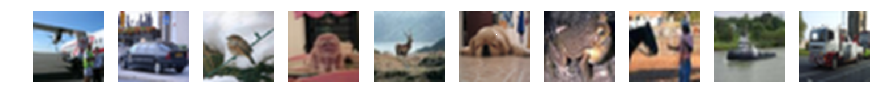

In [33]:
visualize(op_data.reshape(-1,*input_shape), 10, '../figures/test_op')

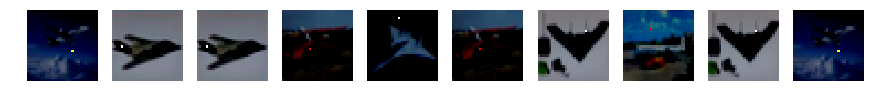

In [26]:
visualize(op_data[x_vis].reshape(-1,*input_shape), 10, '../figures/test_op')

Regular: 


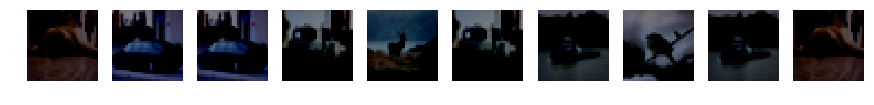

CW-l0: 


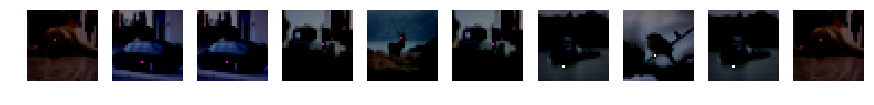

In [18]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-mnist_op')
print ('CW-l0: ')
visualize(op_data[x_vis].reshape(-1,*input_shape), 10, '../figures/op-mnist_op')

In [46]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
op_preds = model.model.predict(op_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
op_labels = preds_to_labels(op_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
op_idx = np.where(np.argmax(op_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
op_data_fil = op_data[op_idx]


#Filter labels to be used
op_labels_fil = op_labels[op_idx]

In [47]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[op_idx], op_data_fil)))

CW-l0: 3.00000


In [16]:
clean_reg = np.zeros(op_data.shape)
for i in range(num_test_samples):
    x_adv = reg_data[i,:,:,0]
    x_hat = dct(x_adv.flatten(),norm='ortho')
    x_hat = get_topk_vec(x_hat,k=40)
    clean_reg[i,:,:,0] = idct(x_hat.flatten(),norm='ortho').reshape(28,28)

In [54]:
n = 125

In [63]:
clean_op_iht = np.zeros(op_data.shape)
for i in range(num_test_samples):
    x_adv_r = op_data[i,:,:,0].flatten()
    x_adv_g = op_data[i,:,:,1].flatten()
    x_adv_b = op_data[i,:,:,2].flatten()
    
    x_hat_r,_ = iht(x_adv_r,t=1, T=100,k=75)
    x_hat_g,_ = iht(x_adv_g,t=1, T=100,k=75)
    x_hat_b,_ = iht(x_adv_b,t=1, T=100,k=75)
    clean_op_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_op_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_op_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

In [71]:
n=125
D = get_matrix(n*n)
A = np.concatenate((D.T,np.identity(n*n)),axis=1)

In [60]:
%%capture thirteen
np.save('data/clean_cifar_op-socp', clean_op_iht)

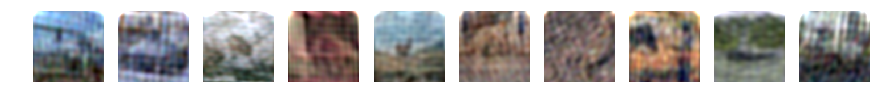

In [64]:
#visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-mnist_op')
visualize(clean_op_iht.reshape(-1,*input_shape), 10, '../figures/op-clean-mnist_op-iht')

In [65]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_op_iht,model.test_labels[test_indices])[1]))

10/10 [==============================] - 0s 2ms/step
Model Accuracy Reconstructed CW-l0: 0.50000
